### Data Loader

In [1]:
import pandas as pd
# plasma_data = pd.read_csv("Zscores_Plasma_SOMA7K_Human_and_HIV_target_Protein_matrix_postQC.csv")
plasma_data = pd.read_csv("Hagerman_matrix.csv", low_memory=False)
plasma_data.shape

(780, 7624)

In [2]:
# plasma_data

In [3]:
phenotype_data = pd.read_excel("Phenotype_Plasma_HAGERMAN_04012024.xlsx", sheet_name='Phenotype')
phenotype_data.shape

(756, 23)

In [4]:
phenotype_data.columns

Index(['UniquePhenoID', 'DrawDate', 'Project', 'ShortPhenoID', 'APOE', 'DOB',
       'BirthYR', 'Age_at_draw', 'Age_onset', 'Age_at_last', 'Sex',
       'Final_Status', 'Closest_CDR_testdate', 'Status_at_draw',
       'CDR_score_closest', 'Status_at_closest_CDR', 'Last_CDR_testdate',
       'Last_CDR_score', 'Status_at_last_CDR', 'ATN_drawdate', 'AT_class',
       'ATN_source', 'Somalogic_ Barcode'],
      dtype='object')

In [7]:
merged_data = pd.merge(plasma_data, phenotype_data, on='UniquePhenoID', how='left')
# merged_data

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import zscore

x_cols = [col for col in merged_data.columns if col.startswith('X')]

# log10 transformation
merged_data[x_cols] = np.log10(merged_data[x_cols] + 1e-8)

# # IQR
# for col in x_cols:
#     Q1 = merged_data[col].quantile(0.25)
#     Q3 = merged_data[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     merged_data.loc[(merged_data[col] < lower_bound) | (merged_data[col] > upper_bound), col] = np.nan

# z-score transformation
merged_data[x_cols] = merged_data[x_cols].apply(zscore, nan_policy='omit')

In [9]:
# merged_data

In [10]:
merged_data['Status_at_draw'].value_counts()

Status_at_draw
ADAD_Presymptomatic_carrier       203
ADAD_Unaffected_Non_carrier       201
ADAD_Affected_carrier             125
CO                                 63
Dystonia_FACE                      49
Dystonia_LD                        49
Dystonia_CD                        45
ADAD_Affected_Non_carrier          11
AD                                  4
ADAD_Clinic_CO_carrier_unknown      1
ADAD_affected_Non_carrier           1
Name: count, dtype: int64

In [11]:
import pandas as pd

summary_list = []

for diagnosis, group in merged_data.groupby('Status_at_draw'):
    n_total = group['UniquePhenoID'].nunique()
    n_female = group[group['Sex'] == 'Female']['UniquePhenoID'].nunique()
    female_percent = (n_female / n_total) * 100 if n_total > 0 else 0

    age_mean = group['Age_at_draw'].mean()
    age_std = group['Age_at_draw'].std()

    summary_list.append({
        'Diagnosis': diagnosis,
        'N': n_total,
        'Female (%)': f"{n_female} ({female_percent:.2f}%)",
        'Age Mean (SD)': f"{age_mean:.1f} ({age_std:.1f})"
    })

summary_df = pd.DataFrame(summary_list).sort_values(by='Diagnosis')

print(summary_df)

                         Diagnosis    N    Female (%) Age Mean (SD)
0                               AD    4    2 (50.00%)   42.8 (10.5)
1        ADAD_Affected_Non_carrier   11    6 (54.55%)   45.3 (12.8)
2            ADAD_Affected_carrier  125   69 (55.20%)    47.5 (9.0)
3   ADAD_Clinic_CO_carrier_unknown    1   1 (100.00%)    30.0 (nan)
4      ADAD_Presymptomatic_carrier  203  111 (54.68%)    36.0 (9.1)
5      ADAD_Unaffected_Non_carrier  201  118 (58.71%)   40.6 (11.4)
6        ADAD_affected_Non_carrier    1     0 (0.00%)    27.0 (nan)
7                               CO   63   60 (95.24%)   52.2 (15.8)
8                      Dystonia_CD   45  45 (100.00%)   60.8 (10.6)
9                    Dystonia_FACE   49  49 (100.00%)    61.3 (8.8)
10                     Dystonia_LD   49  49 (100.00%)   63.3 (10.9)


### Modelling

In [12]:
filtered_data = merged_data.copy()

In [13]:
import joblib
plasma_lgbm_model = joblib.load("plasma_model_output/plasma_lgbm_model_700_0411.pkl")

In [15]:
with open("plasma_model_output/plasma_selected_features_700_0411.txt", "r") as f:
    csf_selected_features = [line.strip() for line in f.readlines()]

csf_selected_features.append('Status_at_draw')

existing_features = [feature for feature in csf_selected_features if feature in filtered_data.columns]

selected_data = filtered_data[existing_features]

print(f"Total selected features: {len(csf_selected_features)}")
print(f"Existing features in dataset: {len(existing_features)}")

Total selected features: 701
Existing features in dataset: 701


In [16]:
missing_features = [feature for feature in csf_selected_features if feature not in filtered_data.columns]

print(f"Missing features ({len(missing_features)}):")
print(missing_features)

Missing features (0):
[]


In [17]:
selected_data['Status_at_draw'].value_counts()

Status_at_draw
ADAD_Presymptomatic_carrier       203
ADAD_Unaffected_Non_carrier       201
ADAD_Affected_carrier             125
CO                                 63
Dystonia_FACE                      49
Dystonia_LD                        49
Dystonia_CD                        45
ADAD_Affected_Non_carrier          11
AD                                  4
ADAD_Clinic_CO_carrier_unknown      1
ADAD_affected_Non_carrier           1
Name: count, dtype: int64

In [18]:
X_new = selected_data.iloc[:, :-1]
print(X_new.shape)

y_pred = plasma_lgbm_model.predict(X_new)
y_pred_proba = plasma_lgbm_model.predict_proba(X_new)

print("Predicted Labels:", y_pred)
print("Predicted Probabilities:\n", y_pred_proba)

(780, 700)
Predicted Labels: [1 0 1 1 1 4 1 1 0 1 4 4 0 1 4 4 4 1 1 1 4 4 0 1 1 1 1 0 4 1 4 4 2 4 4 0 1
 1 4 4 1 1 0 1 4 4 1 1 4 1 0 4 4 4 1 4 4 1 4 1 0 0 0 4 1 4 0 0 0 1 2 0 4 1
 2 0 4 0 4 4 4 4 4 4 0 1 4 4 1 4 4 1 0 4 0 4 1 1 4 4 0 4 0 4 0 4 4 0 1 4 1
 4 4 1 1 1 4 4 4 4 4 4 1 3 0 4 4 2 1 1 4 4 1 4 4 4 1 1 4 0 4 0 4 4 0 1 1 4
 4 4 4 4 1 1 4 4 4 3 4 1 1 4 1 4 4 1 2 4 4 4 1 4 2 1 4 4 0 1 4 4 0 0 1 1 1
 0 1 1 4 0 4 4 4 1 0 1 4 1 4 4 1 4 4 4 4 4 0 0 4 0 0 4 0 4 4 4 4 0 0 4 4 4
 0 4 0 4 2 2 0 4 4 4 1 1 0 4 1 1 2 1 1 1 0 4 0 0 1 0 4 1 4 4 1 4 0 4 1 1 1
 2 1 0 0 4 1 4 1 4 4 0 2 0 0 0 1 0 4 0 4 3 4 4 1 1 4 1 0 0 1 1 0 0 4 4 4 4
 0 0 0 1 1 0 0 0 1 2 0 4 1 1 0 0 4 4 1 4 1 4 4 4 4 0 2 1 2 1 4 1 1 4 0 0 0
 4 4 4 1 2 4 0 4 4 0 0 1 4 1 4 0 4 0 4 0 0 4 1 4 1 4 0 4 4 0 4 4 1 1 1 0 4
 4 1 0 4 1 1 2 1 4 1 4 0 2 1 1 4 1 0 4 1 0 1 1 0 0 0 1 0 2 1 1 1 4 1 0 4 4
 0 1 0 1 1 0 1 0 4 1 0 1 0 4 1 1 1 0 4 1 0 2 4 0 1 0 4 0 1 4 4 1 1 1 4 4 0
 0 0 1 1 1 1 0 4 4 4 1 4 4 1 0 0 1 1 1 4 4 0 1 4 0 4 4 1 0 0 4 0 0 4 0 

In [22]:
UniquePhenoID = filtered_data['UniquePhenoID']
status_labels = selected_data['Status_at_draw'].str.upper()
y_pred_proba_df = pd.DataFrame(y_pred_proba, index=status_labels.index, columns=[f"{label} Probability" for label in ['AD', 'CO', 'DLB', 'FTD', 'PD']])

predicted_classes = y_pred_proba_df.idxmax(axis=1).str.replace(' Probability', '')

results_df = pd.DataFrame({
    "UniquePhenoID": UniquePhenoID,
    "Status_at_draw": status_labels,
    "Predicted Class": predicted_classes
})

results_df = pd.concat([results_df, y_pred_proba_df], axis=1)
# results_df

# results_df.to_csv("Hagerman_Plasma_780_Prediction_Results_700.csv", index=False)

In [23]:
results_df["Status_at_draw"].value_counts()

Status_at_draw
ADAD_PRESYMPTOMATIC_CARRIER       203
ADAD_UNAFFECTED_NON_CARRIER       201
ADAD_AFFECTED_CARRIER             125
CO                                 63
DYSTONIA_FACE                      49
DYSTONIA_LD                        49
DYSTONIA_CD                        45
ADAD_AFFECTED_NON_CARRIER          12
AD                                  4
ADAD_CLINIC_CO_CARRIER_UNKNOWN      1
Name: count, dtype: int64

### Radar Plots

In [24]:
def calculate_mean_and_ci(data, confidence=0.95):
    mean = np.mean(data, axis=0)
    se = np.std(data, axis=0) / np.sqrt(len(data))
    ci = se * 1.96  # 95% CI
    return mean, mean - ci, mean + ci

In [25]:
def plot_radar_chart(mean, lower_ci, upper_ci, title):
    # Extract class labels by removing ' Probability' from column names
    labels = [col.replace(' Probability', '') for col in results_df.columns if 'Probability' in col]
    num_vars = len(labels)

    # Compute angles for each axis on the radar chart
    angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
    angles += angles[:1]  # Close the loop

    # Initialize the radar chart figure
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Repeat the first value to close the radar shape
    mean_values   = list(mean) + [mean[0]]
    lower_ci_vals = list(lower_ci) + [lower_ci[0]]
    upper_ci_vals = list(upper_ci) + [upper_ci[0]]

    # Plot the mean and confidence interval lines
    ax.fill(angles, mean_values, color='#1f77b4', alpha=0.25)
    ax.plot(angles, mean_values, color='#1f77b4', linewidth=2, linestyle='solid', label='Mean')
    ax.plot(angles, lower_ci_vals, color='#1f77b4', linewidth=2, linestyle='dashed', label='95% CI')
    ax.plot(angles, upper_ci_vals, color='#1f77b4', linewidth=2, linestyle='dashed')

    # Configure the axis and labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=28, fontweight='bold')
    ax.set_rlabel_position(0)
    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.set_yticklabels(["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"], fontsize=18, fontweight='bold')

    # Highlight only the direction with the highest mean value
    idx_max = int(np.argmax(mean))

    # Annotate only the max mean value (no CI shown)
    ax.text(angles[idx_max], mean_values[idx_max] + 0.05,
            f'{mean_values[idx_max]:.2f}',
            ha='center', va='center',
            fontsize=28, fontweight='bold', color='black')

    # (Commented out: CI annotations)
    # ax.text(angles[idx_max], lower_ci_vals[idx_max] - 0.05, f'{lower_ci_vals[idx_max]:.2f}', ...)
    # ax.text(angles[idx_max], upper_ci_vals[idx_max] + 0.03, f'{upper_ci_vals[idx_max]:.2f}', ...)

    # Show the plot
    # plt.title(title, fontsize=20, fontweight='bold', y=1.08)  # optional
    plt.tight_layout()
    plt.show()

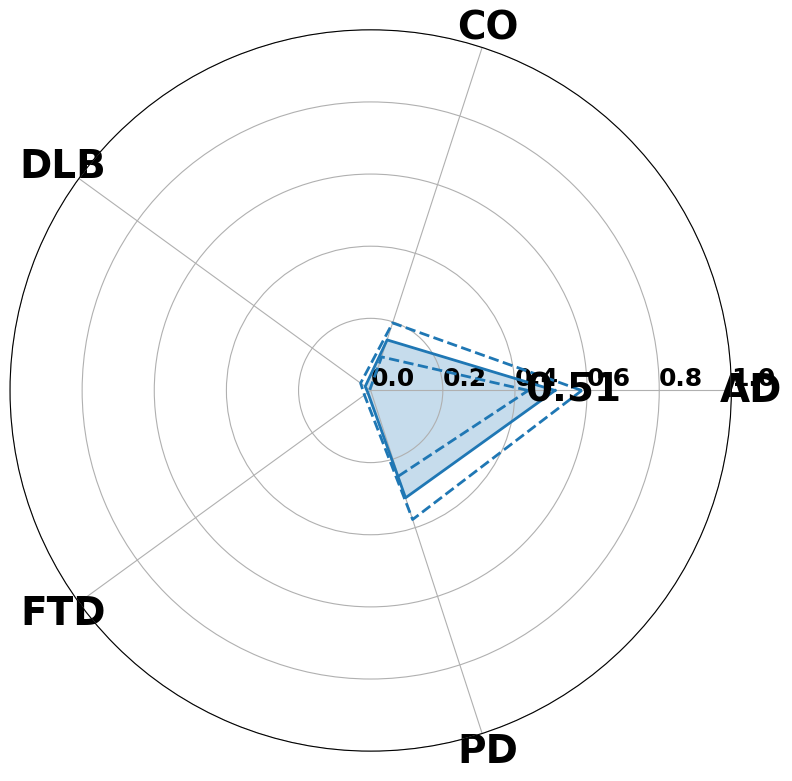

In [27]:
import matplotlib.pyplot as plt
# Loop over target classes to create radar plots for each
for true_class in ['ADAD_AFFECTED_CARRIER']:  # You can add more classes here
    # Filter the dataset to get only samples of the selected class
    subset = results_df[results_df['Status_at_draw'] == true_class]

    # Extract probability columns as NumPy array
    probabilities = subset[[col for col in results_df.columns if 'Probability' in col]].values

    # Compute mean and 95% CI
    mean, lower_ci, upper_ci = calculate_mean_and_ci(probabilities)

    # Generate radar chart
    plot_radar_chart(mean, lower_ci, upper_ci, f'Radar Plot for {true_class}')